# Delay Calculation Validation Experiments

- Note that you'll have to be on an updated branch ... (to be pushed pending exising PRs)
     - There is way to much going on in the current PRs, don't want to add complexity just yet

In [1]:
import os, os.path as op
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
from RAiDER.llreader import BoundingBox
from RAiDER.losreader import Zenith, Conventional, Raytracing
from RAiDER.delay import tropo_delay
from RAiDER.utilFcns import (
    lla2ecef, transform_bbox, clip_bbox, writeResultsToXarray,
    rio_profile,
)
%pdb off

# change this to the directory with the notebook
WD = op.join(op.expanduser('~'), 'Software_InSAR','RAiDER-docs_git','notebooks', 'Synthetic_Test')
os.chdir(WD)
print ('Working directory (WD):', WD)

Automatic pdb calling has been turned OFF
Working directory (WD): /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test


### helper functions

update_wm is the one to edit

In [2]:
def compare_golden(wd, ext='ray'):
    """ Quick check if the synth result is different than real weather wm """
    ds_orig = xr.open_dataset(f'{wd}/golden_data/GMAO_tropo_20181113T230000_{ext}.nc')
    da_dry0 = ds_orig['hydro']
    ds_new  = xr.open_dataset(f'{wd}/Synthetic_tropo_20181113T110000_{ext}.nc')
    da_dry1 = ds_new['hydro']
    equal = np.allclose(da_dry0.data, da_dry1.data, equal_nan=True)
    print ('Orig == synthetic?', equal)
    return

## Hack Weather Model

In [3]:
from RAiDER.models.gmao import GMAO

class GMAOdummy(GMAO):
    def __init__(self):
        super().__init__()
#         self.shp = (13, 12, 145) # unique to this study area (145 height levels)
        self.shp = (21, 22, 145) # unique to this study area (145 height levels)

        self._k1 = 2# 0.776  # [K/Pa]
        self._k2 = 1# 0.233  # [K/Pa]
        self._k3 = 0# 3.75e3  # [K^2/Pa]
        self._p  = np.ones(self.shp) 
        self._e  = np.ones(self.shp) 
        self._t  = np.ones(self.shp)
#         self._zs = self._zlevels # model levels
        self._zs = np.ones(self.shp[-1])

    def _get_wet_refractivity(self):
        '''
        Calculate the wet delay from pressure, temperature, and e
        '''
        self._wet_refractivity = self._k2 * self._e / self._t + self._k3 * self._e / self._t**2
        return self._wet_refractivity
    
    def _get_hydro_refractivity(self):
        '''
        Calculate the hydrostatic delay from pressure and temperature
        '''
        self._hydrostatic_refractivity = self._k1 * self._p / self._t
        return self._hydrostatic_refractivity
    
    def getWetRefractivity(self):
        return self._wet_refractivity

   
    def getHydroRefractivity(self):
        return self._hydrostatic_refractivity

   
    def _getZTD(self, zref=None):
        self._get_wet_refractivity()
        self._get_hydro_refractivity()
        wet   = self.getWetRefractivity()
        hydro = self.getHydroRefractivity()


        # Get the integrated ZTD
        wet_total, hydro_total = np.zeros(wet.shape), np.zeros(hydro.shape)
        for level in range(wet.shape[2]):
            wet_total[..., level] = 1e-6 * np.trapz(
                wet[..., level:], x=self._zs[level:], axis=2
            )
            hydro_total[..., level] = 1e-6 * np.trapz(
                hydro[..., level:], x=self._zs[level:], axis=2
            )
        self._hydrostatic_ztd = hydro_total
        self._wet_ztd = wet_total
        return

In [4]:
def update_wm(wm_file, wet, dry, dry_total=None, wet_total=None):
    """ Edit the pointwise? values in a weather model file 

    write it out with extension _SYNTH
    Return the file name for input into tropo_delay

    wet_total/hydro_total used for zenith/proj
    wet/hydro used for ray
    """
    with xr.open_dataset(wm_file) as ds:
        ds['wet']   = ('z y x'.split(), wet)
        ds['hydro'] = ('z y x'.split(), dry)
        
        if wet_total:
            ds['wet_total']   = ('z y x'.split(), wet_total)
        if dry_total:
            ds['hydro_total'] = ('z y x'.split(), dry_total)
        
    dst = f'{op.splitext(wm_file)[0]}_SYNTH.nc'
    ds.to_netcdf(dst)
    print ('Wrote synthetic weather model file to:', dst)
    return dst


In [5]:
Obj = GMAOdummy()
# Obj._getZTD()

wet = Obj._get_wet_refractivity().transpose(2,0,1)
dry = Obj._get_hydro_refractivity().transpose(2,0,1)

f   = op.join(WD, 'weather_files', 'GMAO_2020_01_30_T13_52_45_32N_37N_121W_115W.nc')
# f   = op.join(WD, 'weather_files', 'GMAO_2018_11_13_T23_00_00_36N_39N_78W_75W.nc')
dst = update_wm(f, wet=wet, dry=dry)
ds  = xr.open_dataset(dst)

Wrote synthetic weather model file to: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/weather_files/GMAO_2020_01_30_T13_52_45_32N_37N_121W_115W_SYNTH.nc


In [ ]:
from RAiDER.utilFcns import (
    lla2ecef, transform_bbox, clip_bbox, writeResultsToXarray,
    rio_profile,
)

wm_proj = rio_profile(f"netcdf:{dst}:t")["crs"]
wm_proj

## Setup Fake Ray Tracing

In [ ]:
import isce3.ext.isce3 as isce
from isce3.core import DateTime, TimeDelta

# degrees
_LON0 = 0
_LAT0 = 0
_OMEGA = 0.1 / (180/np.pi)

In [ ]:
help(isce.core.Ellipsoid)

In [ ]:
def setup_fake_raytracing(lat0, lon0, omega):
    '''This sets up a fake orbit for the weather model'''
    hsat = 700000.
    Nvec = 30

    t0 = DateTime("2017-02-12T01:12:30.0")

    elp = isce.core.Ellipsoid(6378137., .0066943799901)
    look = isce.core.LookSide.Left

    sat_hgt = elp.a + hsat
    sat_lat = np.sin(np.radians(lat0))
    clat = np.cos(np.radians(lat0))

    svs = []
    for k in range(Nvec):
        dt = TimeDelta(100 * k)
        lon = lon0 + omega * dt.total_seconds()

        pos = []
        pos.append(sat_hgt * clat * np.cos(np.radians(lon)))
        pos.append(sat_hgt * clat * np.sin(np.radians(lon)))
        pos.append(sat_hgt * sat_lat)

        vel = []
        vel.append(-omega * pos[1])
        vel.append(omega * pos[0])
        vel.append(0.)

        epoch = t0 + dt

        svs.append(
            isce.core.StateVector(epoch,pos, vel)
        )

    orb = isce.core.Orbit(svs)

    return orb, look, elp, sat_hgt

In [ ]:
orb, look, elp, sat_hgt = setup_fake_raytracing(_LAT0, _LON0, _OMEGA)

## Get/Set defaults

In [ ]:
## Mimic test_scenario_3.py
# dt  = datetime(2018, 11, 13, 23)
# dts = dt.strftime('%Y_%m_%d_T%H_%M_%S')

# height_levels = np.array([0., 100., 500., 1000.])
# aoi = BoundingBox([36.8, 36.85, -76.15, -76.05])
# # aoi.add_buffer(buffer=1.)

# # get redownload (with change to name) with !eof -m S1A -d {dts.replace('_', '')}
# orbit = f'{WD}/S1A_OPER_AUX_POEORB_OPOD_20181203T120749_V20181112T225942_20181114T005942.EOF'

In [7]:
## Mimic LA_ARIA GUNW

dt  = datetime(2020, 1, 30, 13, 52, 45)
dts = dt.strftime('%Y_%m_%d_T%H_%M_%S')

height_levels = np.array([0., 100., 500., 1000.])
aoi = BoundingBox([32.979829, 34.944592, -119.272279, -116.251959])
# aoi.add_buffer(buffer=1.)
orbit = f'{WD}/S1B_OPER_AUX_POEORB_OPOD_20210317T025713_V20200129T225942_20200131T005942.EOF'

### Hack Orbit File

In [52]:
import isce3.ext.isce3 as isce
from RAiDER.losreader import read_ESA_Orbit_file, cut_times, get_orbit

svs = read_ESA_Orbit_file(orbit)
idx = cut_times(svs[0], dt, pad=6000)
svs = [d[idx] for d in svs]

svs0 = svs.copy()

# returns 
#         svs (list of ndarrays): - the times, x/y/z positions and velocities
# ecef?
# of the sensor for the given window around the reference time

In [53]:
# only N/S orbit?
# svs[1] = len(svs[0]) * [np.mean(svs[1])] # x
# svs[1] = len(svs[0]) * [np.median(svs[1])] # x

svs[1] = len(svs[1]) * [svs[1][0]] # x
# svs[4] = len(svs[4]) * [0]
# svs[3] = len(svs[0]) * [np.mean(svs[2])] # z

In [54]:
# basically losreader.get_orbit
svs1  = np.stack(svs, axis=-1)
svs_i = []
for sv in svs1:
    sv = isce.core.StateVector(isce.core.DateTime(sv[0]), sv[1:4], sv[4:7])
    svs_i.append(sv)

orb = isce.core.Orbit(svs_i)

In [55]:
from pyproj import CRS, Transformer
out_snwe = [32.9, 35.0, -119.30000000000001, -116.2]
out_spacing  = 0.1
xpts = np.arange(out_snwe[2], out_snwe[3] + out_spacing, out_spacing)
ypts = np.arange(out_snwe[1], out_snwe[0] - out_spacing, -out_spacing)

xx, yy = np.meshgrid(xpts, ypts)
pts_crs = CRS.from_epsg(4326)

ht  = 0
llh = [xx, yy, np.full(yy.shape, ht)]
xyz = np.stack(lla2ecef(llh[1], llh[0], np.full(yy.shape, ht)), axis=-1)

In [56]:
los = Raytracing(orbit)
los._orbit = orb
los._time  = dt

LOS = los.getLookVectors(ht, llh, xyz, yy)
print ('All nan?', np.isnan(LOS).all())

All nan? True


In [19]:
# # only N/S orbit?
# # svs[1] = len(svs[0]) * [np.mean(svs[1])] # x
# svs[1] = len(svs[0]) * [np.median(svs[1])] # x

# # svs[1] = len(svs[0]) * [svs[1][0]] # x
# # svs[4] = len(svs[4]) * [0]
# # svs[3] = len(svs[0]) * [np.mean(svs[2])] # z
# # basically losreader.get_orbit
# svs1  = np.stack(svs, axis=-1)

# svs_i = []
# for sv in svs1:
#     sv = isce.core.StateVector(isce.core.DateTime(sv[0]), sv[1:4], sv[4:7])
#     svs_i.append(sv)

# orb = isce.core.Orbit(svs_i)
# xpts  = ds.x.data
# ypts  = ds.y.data
# xx, yy = np.meshgrid(xpts, ypts)
# pts_crs = CRS.from_epsg(4326)

# ht  = -500
# llh = [xx, yy, np.full(yy.shape, ht)]
# xyz = np.stack(lla2ecef(llh[1], llh[0], np.full(yy.shape, ht)), axis=-1)
# los = Raytracing(orbit)
# los._oribt = orb
# los._time  = dt

# LOS = los.getLookVectors(ht, llh, xyz, yy)

In [ ]:
los = Zenith()
ext = 'ztd'

# los = Conventional(orbit)
# ext = 'std'

# los = Raytracing(orbit, time=dt)
# ext = 'ray'

In [ ]:
# original weather model file 
# can be redownloaded with !raider.py raider_example_3.yaml
wm0 = f'{WD}/weather_files/GMAO_{dts}_36N_39N_78W_75W.nc'
wm  = update_wm(wm0)

### Compute Delays

In [ ]:
ds  = tropo_delay(dt, wm, aoi, los, height_levels, cube_spacing_m=5000)[0]

In [ ]:
out = f'{WD}/Synthetic_tropo_20181113T110000_{ext}.nc'
ds.to_netcdf(out, mode="w")
print ('Wrote:', out)

### Check against analytical solutions

In [ ]:
compare_golden(WD)

## Questions

- is our hydrostatic equation missing a term?
ours: $$0.776 \frac{P_d}{T}$$
[Li et al, Eq. 2](https://amt.copernicus.org/articles/14/6379/2021/): $$0.776  \frac{P_d}{T} + 0.776 \frac{M_w}{M_d}\frac{P_w}{T}$$

where: $P_d$ (in hPa) is the partial pressure of the dry constituent, $P_w$ (in hPa) is the partial pressure of water vapor, T (in K) is the partial temperature. They don't define $M_w$ and $M_d$/

Meanwhile, from [Stephens et al., Eq. 4](https://www.mdpi.com/2072-4292/12/5/782)(also Jolivet): $$0.776  \frac{R_d}{9.8}(P)$$

where $R_d$ is the specific gas constants for dry air 

Agreement with [Bekaert et al., 2015](https://www.sciencedirect.com/science/article/pii/S0034425715301231):
$$k_1\left(\frac{P}{T}\right)_{hyd} + \left(k_2\frac{e}{T} + k_3\frac{e}{T}^2\right)_{wet}$$


I suppose we ignore the $P_w$ wrt Li et al., but why are we so different from Jolivet?


## Plot Orbits

In [ ]:
xs = np.ones(5)*5
ys = np.arange(5)*2
zs = np.arange(5)

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, color='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [58]:

xs  = svs0[1]
ys  = svs0[2]
zs  = svs0[3]

xs1 = svs[1]
ys1 = svs[2]
zs1 = svs[3]
# xx = np.arange(len(xs))
# xx = np.polyval(np.polyfit(xx, xs, 1), xx)
# xx

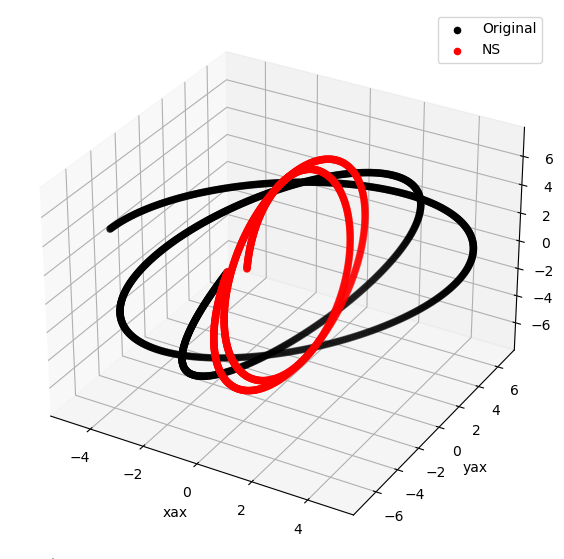

In [61]:
%matplotlib inline


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(xs, ys, zs, color='k', label='Original')
ax.scatter(xs1, ys1, zs1, color='red', label='NS')


ax.set_xlabel('xax')
ax.set_ylabel('yax')
ax.set_zlabel('zax')
ax.legend();

# ax.view_init(elev=20., azim=-35, roll=0)

## Orbit Math

https://github.com/isce-framework/isce3/blob/0eb175f86f6c74d86c19ba9623f23054513fc657/tests/cxx/isce3/geometry/geometry/geometry_constlat.cpp

This unit test compares output of geometry algorithms against analytic solutions
derived for a satellite flying at constant velocity and radius over a line of constant
latitude.
The target is assumed to lie on a sphere with radius equal to Ellipsoid's major axis.
## Geodetic LLH to ECEF XYZ
---------
Radius along the East-West direction ($R_e$) is given by:
$$R_e \left(\theta \right) = \frac{a}{\sqrt{1 - e^2 \cdot \sin^2 \left(\theta \right)}}$$
Using the East-West radius, a given target at Geodetic Latitude ($\theta$), Longitude ($\psi$)
and Height ($h$) can be transformed to Caresian ECEF coordinates as follows:
$$X = \left( R_e\left( \theta \right) + h \right) \cdot \cos \theta \cdot \cos \psi$$
$$Y = \left( R_e\left( \theta \right) + h \right) \cdot \cos \theta \cdot \sin \psi$$
$$Z = \left( R_e\left( \theta \right) \cdot \left( 1 - e^2 \right) +h \right) \cdot \sin \theta $$
## Parametric form of Sphere with Geocentric Latitude
-----------
A point $\vec{S}$ on a sphere at a height $h$ above the major axis characterized by Geocentric
Latitude ($\lambda$), Longitude ($\psi$) can be expressed in ECEF coordinates as follows:
$$ X = \left( a + h \right) \cdot \cos \lambda \cos \psi $$
$$ Y = \left( a + h \right) \cdot \cos \lambda \sin \psi $$
$$ Z = \left( a + h \right) \cdot \sin \lambda $$
## Target on same longitude as satellite is on Zero Doppler Countour
----------
Consider a target ($\vec{T}$) located on the same longitude as the satellite.
Let the location of target ($\vec{T}$) be represented by geocentric latitude $\lambda$,
longitude $\psi$ and zero height .
$$X_t = a \cdot \cos \lambda \cdot \cos \psi$$
$$Y_t = a \cdot \cos \lambda \cdot \sin \psi$$
$$Z_t = a \cdot \sin \lambda $$
Using the above expressions, it can be shown that
$$\left( \vec{R_{s}} - \vec{T} \right) \cdot \vec{V_{s}} = 0$$
Hence, it is sufficient to solve for Target latitude ($\lambda$) when estimating target
on reference surface of ellipsoid ($h_t$) for a given slant range for forward
geometry operations.
## Target on Geocentric sphere with radius a
-----------
For a given slant range ($R$), we can write out
$$ \left( \left( a + h_s \right) \cdot \cos \lambda_s  -   a \cdot \cos \lambda \right)^2$$
$$ + \left( \left( a +h_s \right) \cdot \sin \lambda_s - a \cdot \sin \lambda \right)^2 = R^2$$
Leading to
$$\cos \left( \lambda - \lambda_s \right) = \frac{1}{2} \cdot \left[ \frac{a+h_s}{a} + \frac{a}{a+h_s} - \frac{R}{a} \cdot \frac{R}{a+h_s} \right] $$